# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [59]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import jacfwd

In [60]:
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")

In [61]:
def read_G2o_file(filename, after_fix=False):
    with open(filename, 'r') as f:
        lines = f.readlines()
    ver_x, ver_y, ver_theta = [], [], []
    
    edge_i, edge_j = [], []
    edge_x, edge_y, edge_theta = [], [], []
    info_x, info_y, info_theta = [], [], []
    
    read = not after_fix
    
    for line in lines:
        if "VERTEX_SE2" in line and read:
            _, _, x, y, theta = line.strip().split()
            
            ver_x.append(float(x))
            ver_y.append(float(y))
            ver_theta.append(float(theta))
            
        elif "EDGE_SE2" in line and read:
            _, i, j, x, y, theta, sigma_x, _, _, sigma_y, _, sigma_theta = line.strip().split()
            
            edge_i.append(int(i))
            edge_j.append(int(j))
            
            edge_x.append(float(x))
            edge_y.append(float(y))
            edge_theta.append(float(theta))
            
            info_x.append(float(sigma_x))
            info_y.append(float(sigma_y))
            info_theta.append(float(sigma_theta))
            
        elif "FIX 0" in line:
            read = not read
    vertex = np.array([ver_x, ver_y, ver_theta])
    edge = np.array([edge_i, edge_j, edge_x, edge_y, edge_theta, info_x, info_y, info_theta])
    
    return vertex, edge

In [62]:
vertex, edge = read_G2o_file('../data/edges.txt')
postfix_vertex, postfix_edge = read_G2o_file('../data/edges.txt', after_fix=True)

In [63]:
def next_pose(x, y, theta, index, edge):
    x = x + (edge[2][index]*np.cos(theta)) - (edge[3][index]*np.sin(theta))
    y = y + (edge[3][index]*np.cos(theta)) + (edge[2][index]*np.sin(theta))
    theta = theta + edge[4][index]
    return x, y, theta

def motion_model(vertex, edge):
    X, Y, THETA = [], [], []
    
    x, y, theta = vertex.tolist()
    
    X.extend(x), Y.extend(y), THETA.extend(theta)
    
    for index in range(edge.shape[-1]):
        x, y, theta = next_pose(x, y, theta, index, edge)
        
        X.extend(x), Y.extend(y), THETA.extend(theta)
    return X, Y, THETA

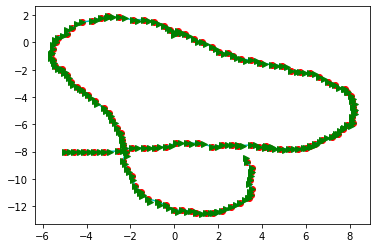

In [64]:
X, Y, THETA = motion_model(vertex, edge)
draw(X, Y, THETA)

In [65]:
def save_to_G2o_file(filename, vertex, edge, postfix_vertex, postfix_edge):
    
    X, Y, THETA = motion_model(vertex, edge)
    
    g2o = open(filename,'w')
    for index, (x, y, theta) in enumerate(zip(X,Y,THETA)):
        line = f'VERTEX_SE2 {index} {x} {y} {theta}'
        g2o.write(line)
        g2o.write("\n")
    
    for index in range(edge.shape[-1]):
        line = f'EDGE_SE2 {int(edge[0][index])} {int(edge[1][index])} {edge[2][index]} {edge[3][index]} {edge[4][index]} {edge[5][index]} 0.0 0.0 {edge[6][index]} 0.0 {edge[7][index]}'
        g2o.write(line)
        g2o.write("\n")
        
    g2o.write("FIX 0\n")
    
    for index in range(postfix_edge.shape[-1]):
        line = f'EDGE_SE2 {int(postfix_edge[0][index])} {int(postfix_edge[1][index])} {postfix_edge[2][index]} {postfix_edge[3][index]} {postfix_edge[4][index]} {postfix_edge[5][index]} 0.0 0.0 {postfix_edge[6][index]} 0.0 {postfix_edge[7][index]}'
        g2o.write(line)
        g2o.write("\n")
        
    print(f"{filename} saved successfully!!")

In [66]:
save_to_G2o_file('../data/edges-poses.g2o', vertex, edge, postfix_vertex, postfix_edge)

../data/edges-poses.g2o saved successfully!!


In [9]:
##############################################################################
# TODO: Code for Section 2.1                                                 #
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))
        
        if "FIX 0" in line:
            return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

def readEdge_after_FIX(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []
    flag = False
    for line in A:
        if "FIX 0" in line:
            flag = True
        
        if "EDGE_SE2" in line and flag == True:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))
        
    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))
        
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()
    
def plot_traj_comparison(X, Y, THETA):
    xgt, ygt, thetagt = readVertex("../data/gt.txt")
    xn, yn, thetan = readVertex("edges-poses.g2o")
    ax = plt.subplot(111)
    ax.plot(xgt, ygt, 'go',label = 'Ground Truth')
    plt.plot(xgt, ygt, 'c-')
    ax.plot(xn, yn, 'ro', label = 'Noisy')
    plt.plot(xn, yn, 'c-')
    ax.plot(X,Y,'bo',label = 'Optimized')
    plt.plot(X, Y, 'b-')
    
    for i in range(len(thetagt)):
        x2 = 0.25*math.cos(thetagt[i]) + xgt[i]
        y2 = 0.25*math.sin(thetagt[i]) + ygt[i]
        plt.plot([xgt[i], x2], [ygt[i], y2], 'g->')
    
    for i in range(len(thetan)):
        x2 = 0.25*math.cos(thetagt[i]) + xn[i]
        y2 = 0.25*math.sin(thetagt[i]) + yn[i]
        plt.plot([xn[i], x2], [yn[i], y2], 'r->')
        
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'b->')
    
    plt.legend()
    plt.show()


def generate_traj(filename):
    x, y, theta = readVertex(filename)
    i, j, del_x, del_y, del_theta = readEdge(filename)
    ik, jk, del_xk, del_yk, del_thetak = readEdge_after_FIX(filename)
    n = len(i)
    X,Y, Theta = [], [], []
    X.append(x)
    Y.append(y)
    Theta.append(theta)
    for idx in range(n):
        temp_x = x + (del_x[idx]*jnp.cos(theta)) - (del_y[idx]*jnp.sin(theta))
        temp_y = y + (del_y[idx]*jnp.cos(theta)) + (del_x[idx]*jnp.sin(theta))
        temp_t = theta + del_theta[idx]
        X.append(temp_x)
        Y.append(temp_y)
        Theta.append(temp_t)
        x, y, theta = temp_x, temp_y, temp_t
        '''
        if(idx == n-2):
            X.append(del_x[idx+1]+x)
            Y.append(del_y[idx+1]+y)
            Theta.append(del_theta[idx+1]+theta)
        '''
        
        
    g2o = open('edges-poses.g2o','w')
    for idx, (x, y, theta) in enumerate(zip(X,Y,Theta)):
        line = "VERTEX_SE2" + " " + str(idx) + " " + str(x[0]) + " " + str(y[0]) + " " + str(theta[0])
        g2o.write(line)
        g2o.write("\n")
    
    info_mat = "500.0 0.0 0.0 500.0 0.0 500.0"
    for idx, (i, j, del_x, del_y, del_theta) in enumerate(zip(i, j, del_x, del_y, del_theta)):
        line = "EDGE_SE2" + " " + str(i) + " " + str(j) + " " + str(del_x) + " " + str(del_y) + " " + str(del_theta) + " " + str(info_mat)
        g2o.write(line)
        g2o.write("\n")
        
    g2o.write("FIX 0")
    g2o.write("\n")
    info_mat = "700.0 0.0 0.0 700.0 0.0 700.0"
    for idx, (i, j, del_x, del_y, del_theta) in enumerate(zip(ik, jk, del_xk, del_yk, del_thetak)):
        line = "EDGE_SE2" + " " + str(i) + " " + str(j) + " " + str(del_x) + " " + str(del_y) + " " + str(del_theta) + " " + str(info_mat)
        g2o.write(line)
        g2o.write("\n")
        
    print("Trajectory Generated and file(edges-poses.g2o) is saved successfully..")
    draw(X, Y, Theta)
    
def save_opt_pose(X, Y, Theta):
    X = jnp.asarray(X)
    Y = jnp.asarray(Y)
    Theta = jnp.asarray(Theta)
    g2o = open('opt.g2o','w')
    for idx, (x, y, theta) in enumerate(zip(X, Y, Theta)):
        line = "VERTEX_SE2" + " " + str(idx) + " " + str(x) + " " + str(y) + " " + str(theta)
        g2o.write(line)
        g2o.write("\n")
        
    print("Optimized File (opt.g2o) is saved successfully...")
    
def get_d(x, y, theta, del_x, del_y, del_theta, idx_i, idx_j):
    f_x, f_y, f_t, f = [], [], [], []
    u_x, u_y, u_theta, u = [], [], [], []
    data = []
    dataxyt = []
    uxyt = []
    n = len(x)
    for idx in range(n):
        u_x.append((del_x[idx]*jnp.cos(theta[idx])) - (del_y[idx]*jnp.sin(theta[idx])))
        u_y.append((del_y[idx]*jnp.cos(theta[idx])) + (del_x[idx]*jnp.sin(theta[idx])))
        u_theta.append(del_theta[idx])
    u_x = jnp.asarray(u_x)
    u_y = jnp.asarray(u_y)
    u_theta = jnp.asarray(u_theta)
    for i,j,k in zip(u_x, u_y, u_theta):
        uxyt.append(i)
        uxyt.append(j)
        uxyt.append(k)
    uxyt = jnp.asarray(uxyt)
    uxyt = uxyt.ravel()
    for i,j,k in zip(x, y, theta):
        dataxyt.append(i)
        dataxyt.append(j)
        dataxyt.append(k)
    dataxyt = jnp.asarray(dataxyt)
    dataxyt = dataxyt.ravel()
    
    u.append((u_x, u_y, u_theta))
    u = jnp.asarray(u)
    u = u.ravel()
    data.append((x,y,theta))    
    data = jnp.asarray(data)
    data = data.ravel()
    
    return data, u, dataxyt, uxyt 

def jacobian_analytical(idx_i, idx_j):
    jacob = []
    dim = 0
    data_dim = 0
    k = 0
    for out in range(360):
        jac = jnp.zeros(420)
        for dim in range(3):
            incr = 0
            for inner in range(dim,417,3):
                #print(inner)
                i = idx_i[incr]
                j = idx_j[incr]
                #print(i,j)
                if dim == data_dim:
                    if k == i:
                        jac = index_update(jac, index[inner], 1)
                    elif k == j:
                        jac = index_update(jac, index[inner], -1)
                
                elif dim != data_dim :
                    jac = index_update(jac, index[inner], 0)
                    
                incr += 1
                
            if k == 0 and dim == data_dim:
                jac = index_update(jac, index[417+dim], 1)
            else:
                jac = index_update(jac, index[417+dim], 0)
            
        k += 1
        if k == 120:
            k = 0
            data_dim += 1
            
        jacob.append(jac)
    return jnp.asarray(jacob).T

def calculate_sigma(idx_i, idx_j, odo=100, loop=500, world=1000):
    a = []
    for i,j in zip(idx_i, idx_j):
        if i == j-1:
            a.append(odo)
            a.append(odo)
            a.append(odo)
        elif i != j-1:
            a.append(loop)
            a.append(loop)
            a.append(loop)
    a.append(world)
    a.append(world)
    a.append(world)
    a = jnp.asarray(a)
    sigma = jnp.diag(a)

    return sigma

def residual(data, u, idx_i, idx_j):
    # print(data, u, idx_i, idx_j)
    f_x = []
    for e,(i,j) in enumerate(zip(idx_i, idx_j)):
        f_x.append(data[i] + u[i] - data[j])
        f_x.append(data[i+120] + u[i+120] - data[j+120])
        f_x.append(data[i+240] + u[i+240] - data[j+240])
    
    f_x.append(data[0] + 5)
    f_x.append(data[120] + 8)
    f_x.append(data[240] - 0)
    
    f = jnp.asarray(f_x)
    f = f.ravel()       
    return f

def data_rearrange(dataxyt):
    x, y, theta = [], [], []
    data = []
    for i in range(0,len(dataxyt),3):
        x.append(dataxyt[i])
        y.append(dataxyt[i+1])
        theta.append(dataxyt[i+2])

    x = jnp.asarray(x)
    x = x.ravel()
    y = jnp.asarray(y)
    y = y.ravel()

    theta = jnp.asarray(theta)
    theta = theta.ravel()
    
    data.append((x,y,theta))
    data = jnp.asarray(data)
    data = data.ravel()
    return data, x,y,theta

def update_step(old, lr, delta):
        new = old - (lr*delta)
        return new
    
def data_rearrange(dataxyt):
    x, y, theta = [], [], []
    data = []
    for i in range(0,len(dataxyt),3):
        x.append(dataxyt[i])
        y.append(dataxyt[i+1])
        theta.append(dataxyt[i+2])

    x = jnp.asarray(x)
    x = x.ravel()
    y = jnp.asarray(y)
    y = y.ravel()

    theta = jnp.asarray(theta)
    theta = theta.ravel()
    
    data.append((x,y,theta))
    data = jnp.asarray(data)
    data = data.ravel()
    return data, x,y,theta
    
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")
    
def compareJacobians(filename, path):
    x, y, theta = readVertex(filename)
    i, j, del_x, del_y, del_theta = readEdge(filename)
    ik, jk, del_xk, del_yk, del_thetak = readEdge_after_FIX(filename)
    idx_i = jnp.append(i, ik)
    idx_j = jnp.append(j, jk)
    delx = jnp.append(del_x, del_xk)
    dely = jnp.append(del_y, del_yk)
    deltheta = jnp.append(del_theta, del_thetak)
    data, u, dataxyt, uxyt = get_d(x, y, theta, delx, dely, deltheta, idx_i, idx_j)
    
    func = lambda data : residual(data, u, idx_i, idx_j)
    jaxjac = jacfwd(func)
    Jaxj = jaxjac(data)
    if os.path.isfile(path):
        Janal = jnp.load(path)
    else:
        #Janal = jacobian_analytical(idx_i, idx_j)
        #jnp.save('analytical_jacobian', Janal)
        print("Note:")
        print("1. Either file (analytical_jacobian.npy) not present or") 
        print("2. File is present in folder but need to give absolute path while passing in function compareJacobians(),")
        print("Example:-")
        print("filename = 'edges-poses.g2o'")
        print("analyticalJ_file = '/home/user/project1/analytical_jacobian.npy'")
        print("compareJacobians(filename, analyticalJ_file)")
        return True
    
    print("###########################################################")
    print("Comparison between Jax Jacobian and Analytical Jacobian")
    frobNorm(Jaxj,Janal)
    print("###########################################################")

def pose_graph(filename, itr_num, odo=10, loop=100, world=1000):
    x, y, theta = readVertex(filename)
    i, j, del_x, del_y, del_theta = readEdge(filename)
    ik, jk, del_xk, del_yk, del_thetak = readEdge_after_FIX(filename)
    idx_i = jnp.append(i, ik)
    idx_j = jnp.append(j, jk)
    delx = jnp.append(del_x, del_xk)
    dely = jnp.append(del_y, del_yk)
    deltheta = jnp.append(del_theta, del_thetak)
    data, u, dataxyt, uxyt = get_d(x, y, theta, delx, dely, deltheta, idx_i, idx_j)

    #Calculate Sigma
    sigma = calculate_sigma(idx_i, idx_j, odo, loop, world)
    
    # initialization
    lambda_val = 10
    prev_loss = 0
    
    # Jax jacobian function
    func = lambda data : residual(data, u, idx_i, idx_j)

    for i in range(itr_num):
        # Calculate residual
        r = residual(data, u, idx_i, idx_j)
        
        # Jax Jacobian
        jaxjac = jacfwd(func)
        J = jaxjac(data)
        
        # H and delta calculation
        H = J.T @ sigma @ J
        eye = lambda_val * jnp.eye(H.shape[0])
        delta = jnp.linalg.inv(H + eye) @ J.T @ sigma.T @ r 
        
        # Compute loss
        loss_i = (r.T @ sigma @ r) / 2
        
        # Update step and damping factor
        if prev_loss == 0 or prev_loss > loss_i:
            data -= 0.9*delta
            x = data[0:120]
            y = data[120:240]
            theta = data[240:]
            lambda_val /= 10
            
        elif prev_loss <= loss_i:
            lambda_val *= 10
         
        print("Iteration no. : {}, Loss : {}".format(i, loss_i))
        prev_loss = loss_i
        #draw(x,y, theta)
        plot_traj_comparison(x,y,theta)
        if loss_i <= 20:
            print("Loss less than 20. Stopping the iterations....")
            return x,y,theta
            break
            
        if i == itr_num-1 :
            print("Max iterations reached, Exiting...")
            return x,y,theta
        #if i % 10 == 0 :
            #loss_i = (r.T @ sigma @ r) / 2
            #print("Iteration no. : {}, Loss : {}".format(i, loss_i))
            #draw(x,y, theta)
    
             
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Trajectory Generated and file(edges-poses.g2o) is saved successfully..


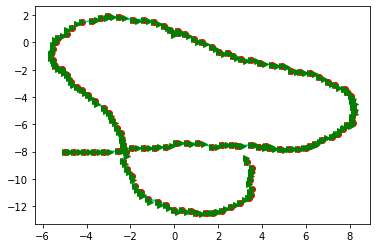

In [10]:
filename = '../data/edges.txt'
generate_traj(filename)

Iteration no. : 0, Loss : 92854.7421875


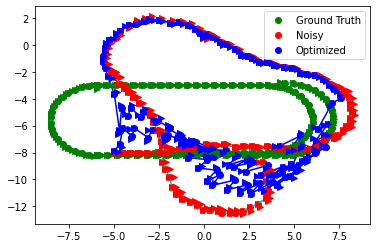

Max iterations reached, Exiting...
Optimized File (opt.g2o) is saved successfully...


In [11]:
filename = 'edges-poses.g2o'
#pose_graph(filename, itr_num = 100, lr = 0.001, odo=500, loop=700, world=1000)
x,y,theta = pose_graph(filename, 1, 10, 100, 1000)

# Save the optimized file
save_opt_pose(x, y, theta)

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [76]:
def get_pose(vertex, edge):
    
    delta_x, delta_y, delta_theta = [], [], []
    
    num_pose = vertex.shape[-1]
    for index in range(num_pose):
        delta_x.append(edge[2][index]*np.cos(vertex[2][index]) - edge[3][index]*np.sin(vertex[2][index]))
        delta_y.append(edge[3][index]*np.cos(vertex[2][index]) + edge[2][index]*np.sin(vertex[2][index]))
        delta_theta.append(edge[4][index])
    U = np.array([delta_x, delta_y, delta_theta])
    U = np.ravel(U)
    
    X = np.ravel(vertex)
    return X, U

def get_information_matrix(edge, INFO_OD, INFO_LOOP, INFO_WORLD):
    diag = []
    for index in range(edge[:2, :].shape[-1]):
        i, j = edge[0][index], edge[1][index]
        if i+1 == j:
            diag.extend([INFO_OD]*3)
        else:
            diag.extend([INFO_LOOP]*3)
    diag.extend([INFO_WORLD]*3)
    return np.diag(diag)

def get_residual(X, U, edge, num_poses):
    
    f_x = []
    for index in range(edge.shape[-1]):
        i, j = int(edge[0][index]), int(edge[1][index])
        f_x.append(X[i] + U[i] - X[j])
        f_x.append(X[i+num_poses] + U[i+num_poses] - X[j+num_poses])
        f_x.append(X[i+2*num_poses] + U[i+2*num_poses] - X[j+2*num_poses])

    f_x.append(X[0] + 5)
    f_x.append(X[num_poses] + 8)
    f_x.append(X[2*num_poses] - 0)
    
    return np.array(f_x)
    
def get_jacobian(X, U, edge, num_poses):
    f_x = get_residual(X, U, edge, num_poses)
    
    h = 0.001

    jacobian = []
    for i, param in enumerate(X):
        X_ = X.copy()
        X_[i] += h
        f_x_h = get_residual(X_, U, edge, num_poses)
        partial_derv = (f_x_h - f_x) / h
        jacobian.append(partial_derv)
    jacobian = np.array(jacobian).T

    return jacobian
    
def slam_2d(filename, LAMBDA=10, MAX_ITR=3, INFO_OD=5, INFO_LOOP=700, INFO_WORLD=1000):
    vertex, edge = read_G2o_file(filename)
    _, postfix_edge = read_G2o_file(filename, after_fix=True)
    
    num_poses = vertex.shape[-1]
    
    edge = np.concatenate((edge, postfix_edge), axis=1)
    
    X, U = get_pose(vertex, edge)
    
    sigma = get_information_matrix(edge, INFO_OD, INFO_LOOP, INFO_WORLD)
    
    prev_error = 10**9
    for ITR in range(MAX_ITR):
        R = get_residual(X, U, edge, num_poses)
        J = get_jacobian(X, U, edge, num_poses)
        
        H = J.T @ sigma @ J
        I = LAMBDA * np.eye(H.shape[0])
        
        delta = np.linalg.inv(H + I) @ J.T @ sigma.T @ R
        
        error = (R.T @ sigma @ R) / 2
        
        if prev_error > error:
            X -= delta
            LAMBDA /= 10
        else:
            LAMBDA *= 10
        
        prev_error = error
        
        print(f"Iteration: {ITR}, Error: {error}")
            
            

j2 = slam_2d("./edges-poses.g2o", MAX_ITR=10)

Iteration: 0, Error: 649983.2234416475
Iteration: 1, Error: 1421.8263866505824
Iteration: 2, Error: 96.51385126698054
Iteration: 3, Error: 33.722023449972
Iteration: 4, Error: 16.447867953022868
Iteration: 5, Error: 12.309480729028667
Iteration: 6, Error: 12.257258519245006
Iteration: 7, Error: 12.257250094619927
Iteration: 8, Error: 12.257250094605993
Iteration: 9, Error: 12.257250094605993


## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.